In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner
import copy

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params, m_set='J1226_A', w_set='J1226'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+f'data/bestfit_PT_{m_set}.pkl')
    Chem = af.pickle_load(prefix+f'data/bestfit_Chem_{m_set}.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{m_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{m_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{m_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{m_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{m_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{m_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
prefix_1 = './retrieval_outputs/KshiftH2_J_B_ret_2/test_'
n_params_1 = 23

res = read_results(prefix=prefix_1, n_params=n_params_1)
posterior_1, bestfit_1, PT_1, Chem_1, _, _, _, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res
del res

prefix_2 = './retrieval_outputs/custom_line_opacity_J_B_ret_5/test_'
n_params_2 = 23

res = read_results(prefix=prefix_2, n_params=n_params_2)
posterior_2, bestfit_2, PT_2, Chem_2, _, _, _, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res
del res

  analysing data from ./retrieval_outputs/KshiftH2_J_B_ret_2/test_.txt
  analysing data from ./retrieval_outputs/custom_line_opacity_J_B_ret_5/test_.txt


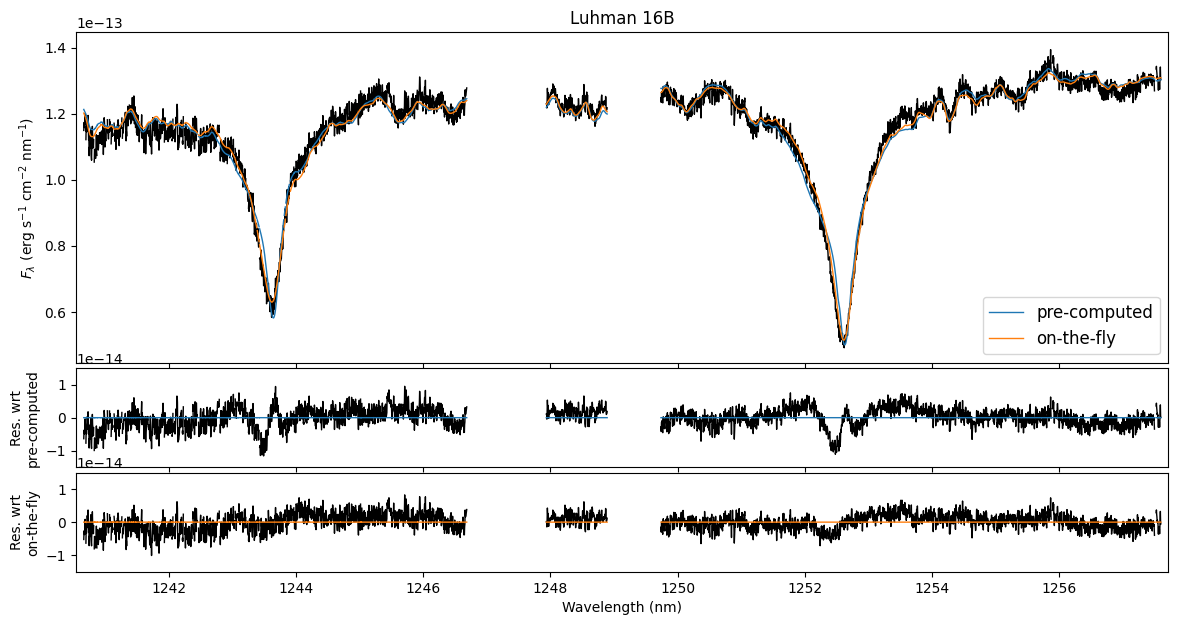

In [3]:
#h_ratios = [0.5,0.25,0.25]
h_ratios = [0.6,0.18,0.18]
m_lw = 1

fig, ax = plt.subplots(
    figsize=(12,6.5), nrows=3, sharex=True, 
    gridspec_kw={
        'height_ratios':h_ratios, 'hspace':0.03, 
        'left':0.07, 'right':0.98, 'top':0.93, 'bottom':0.1
        }
    )
ax = np.array(list(ax))
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        #if j != 0:
        #    continue
        labels = [None, None, None, None, None]
        if j == 0:
            #labels = ['Symmetric', '(P,T)-dependent\nimpact- shift/width']
            #labels = ['Shift', 'Shift+D1 shoulder']
            #labels = ['vdW', 'K-He', 'K-H2', 'K-(H2+He)', 'K-(He table)']
            labels = ['pre-computed', 'on-the-fly']

        ax[0].plot(d_spec_1.wave[i,j], d_spec_1.flux[i,j], c='k', lw=1)
        for k, LogLike_k in enumerate([LogLike_1,LogLike_2]):

            if j == 0:
                ax[k+1].set_ylabel('Res. wrt\n'+f'{labels[k]}')

            ax[0].plot(d_spec_1.wave[i,j], LogLike_k.m_flux_phi[i,j], c=f'C{k}', lw=m_lw, label=labels[k])
            
            ax[k+1].plot(d_spec_1.wave[i,j], d_spec_1.flux[i,j]-LogLike_k.m_flux_phi[i,j], c='k', lw=1)

            l = k
            ax[k+1].plot(d_spec_1.wave[i,j], LogLike_k.m_flux_phi[i,j]*0., c=f'C{l}', lw=m_lw)

            #ax[k+1].plot(d_spec_1.wave[i,j], LogLike_5.m_flux_phi[i,j]-LogLike_k.m_flux_phi[i,j], c=f'C5', lw=m_lw)

            #for l, LogLike_l in enumerate([LogLike_1,LogLike_2,LogLike_3,LogLike_4]):
            #    ax[k+1].plot(d_spec_1.wave[i,j], LogLike_l.m_flux_phi[i,j]-LogLike_k.m_flux_phi[i,j], c=f'C{l}', lw=m_lw)

#ax[0].set(xlim=(1240.5,1246))
#ax[0].set(ylim=(4e-14,1e-13))
ax[0].set(xlim=(d_spec_1.wave[0,0].min(), d_spec_1.wave[0,1].max()))
        
ax[0].legend(loc='lower right', fontsize=12)
ylim0 = np.array(list(ax[0].get_ylim()))

ylim1 = np.array([-1,+1]) * np.abs(np.diff(ylim0)/2) * h_ratios[1]/h_ratios[0]
for ax_i in ax[1:]:
    ax_i.set(ylim=ylim1)

ax[0].set(
    ylabel=r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', 
    title='Luhman 16B'
    )
ax[-1].set(
    xlabel=r'Wavelength (nm)', 
    )
#plt.savefig('./plots/K_asymmetric_fit.pdf')
#plt.savefig('./plots/Knearwing_Kshift.pdf')
#plt.savefig('./figures/plots/K_asymmetry_Luhman_16B.pdf')
plt.show()

In [9]:
#prefix_1 = './retrieval_outputs/K_Voigt_J_A_ret_1/test_'
#w_set_1  = 'J1226'; n_params_1 = 21
prefix_1 = './retrieval_outputs/Ksymm_J_B_ret_2/test_'
n_params_1 = 23

res = read_results(prefix=prefix_1, n_params=n_params_1)
posterior_1, bestfit_1, PT_1, Chem_1, _, _, _, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res
del res

#prefix_2 = './retrieval_outputs/K_asymmetric_J_A_ret_1/test_'
#w_set_2  = 'J1226'; n_params_2 = 21
#prefix_2 = './retrieval_outputs/K_nearwing_J_A_ret_1/test_'
#w_set_2  = 'J1226'; n_params_2 = 23
prefix_2 = './retrieval_outputs/KshiftHe_J_B_ret_1/test_'
n_params_2 = 23

res = read_results(prefix=prefix_2, n_params=n_params_2)
posterior_2, bestfit_2, PT_2, Chem_2, _, _, _, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res
del res

prefix_3 = './retrieval_outputs/KshiftH2_J_B_ret_2/test_'
n_params_3 = 23

res = read_results(prefix=prefix_3, n_params=n_params_3)
posterior_3, bestfit_3, PT_3, Chem_3, _, _, _, m_spec_3, d_spec_3, LogLike_3, Cov_3, bestfit_params_3 = res
del res

prefix_4 = './retrieval_outputs/K_H2He_J_B_ret_1/test_'
n_params_4 = 23

res = read_results(prefix=prefix_4, n_params=n_params_4)
posterior_4, bestfit_4, PT_4, Chem_4, _, _, _, m_spec_4, d_spec_4, LogLike_4, Cov_4, bestfit_params_4 = res
del res

prefix_5 = './retrieval_outputs/K_He_table_J_B_ret_1/test_'
n_params_5 = 23

res = read_results(prefix=prefix_5, n_params=n_params_5)
posterior_5, bestfit_5, PT_5, Chem_5, _, _, _, m_spec_5, d_spec_5, LogLike_5, Cov_5, bestfit_params_5 = res
del res

  analysing data from ./retrieval_outputs/Ksymm_J_B_ret_2/test_.txt
  analysing data from ./retrieval_outputs/KshiftHe_J_B_ret_1/test_.txt
  analysing data from ./retrieval_outputs/KshiftH2_J_B_ret_2/test_.txt
  analysing data from ./retrieval_outputs/K_H2He_J_B_ret_1/test_.txt
  analysing data from ./retrieval_outputs/K_He_table_J_B_ret_1/test_.txt


In [10]:
X = np.concatenate((
    d_spec_1.wave.flatten()[None,:], d_spec_1.flux.flatten()[None,:]
)).T
np.savetxt('./doublet_data/Luhman_16B_doublet.dat', X)

for LogLike_k, label_k in zip([LogLike_1,LogLike_2,LogLike_3,LogLike_4,LogLike_5], ['vdW','K_He','K_H2','K_H2He','K_He_table']):
    X = np.concatenate((
        d_spec_1.wave.flatten()[None,:], LogLike_k.m_flux_phi.flatten()[None,:]
    )).T
    np.savetxt(f'./doublet_data/doublet_model_{label_k}.dat', X)

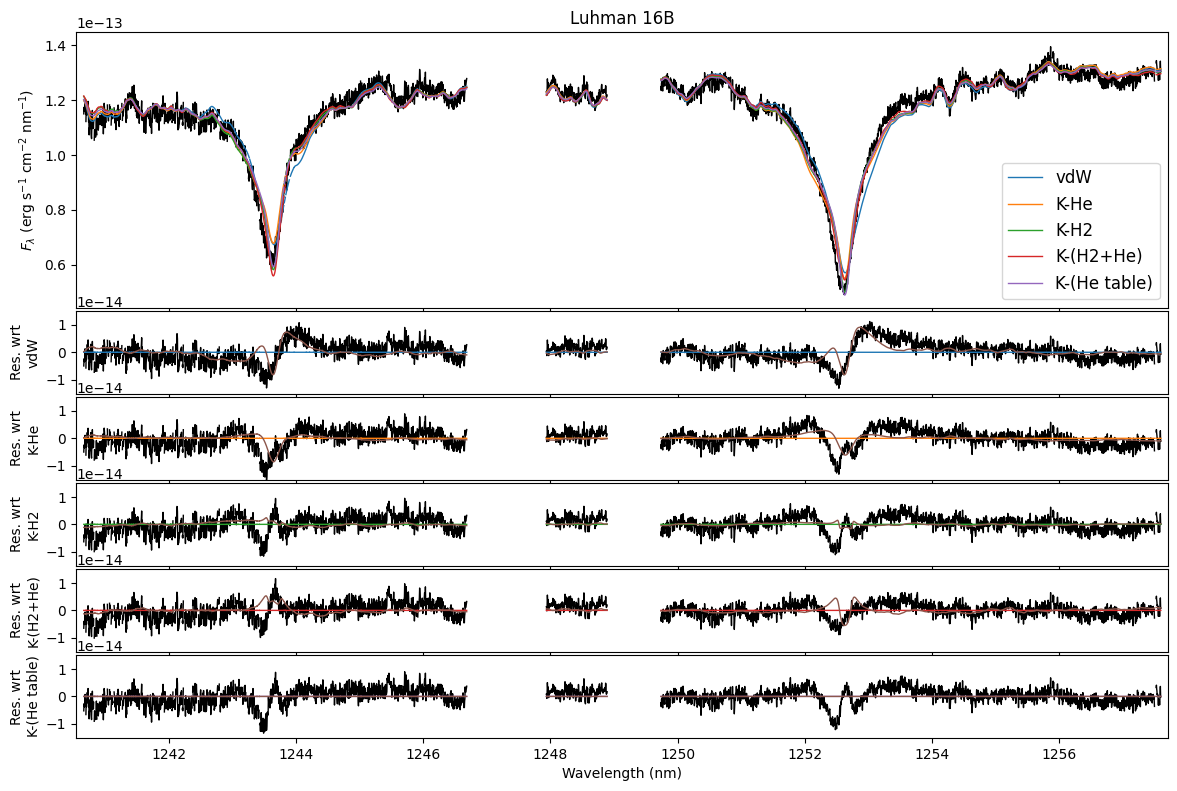

In [15]:
#h_ratios = [0.5,0.25,0.25]
h_ratios = [0.6,0.18,0.18,0.18,0.18, 0.18]
m_lw = 1

fig, ax = plt.subplots(
    figsize=(12,8.5), nrows=6, sharex=True, 
    gridspec_kw={
        'height_ratios':h_ratios, 'hspace':0.03, 
        'left':0.07, 'right':0.98, 'top':0.93, 'bottom':0.1
        }
    )
ax = np.array(list(ax))
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        #if j != 0:
        #    continue
        labels = [None, None, None, None, None]
        if j == 0:
            #labels = ['Symmetric', '(P,T)-dependent\nimpact- shift/width']
            #labels = ['Shift', 'Shift+D1 shoulder']
            labels = ['vdW', 'K-He', 'K-H2', 'K-(H2+He)', 'K-(He table)']

        ax[0].plot(d_spec_1.wave[i,j], d_spec_1.flux[i,j], c='k', lw=1)
        for k, LogLike_k in enumerate([LogLike_1,LogLike_2,LogLike_3,LogLike_4,LogLike_5]):

            if j == 0:
                ax[k+1].set_ylabel('Res. wrt\n'+f'{labels[k]}')

            ax[0].plot(d_spec_1.wave[i,j], LogLike_k.m_flux_phi[i,j], c=f'C{k}', lw=m_lw, label=labels[k])
            
            ax[k+1].plot(d_spec_1.wave[i,j], d_spec_1.flux[i,j]-LogLike_k.m_flux_phi[i,j], c='k', lw=1)

            l = k
            ax[k+1].plot(d_spec_1.wave[i,j], LogLike_k.m_flux_phi[i,j]*0., c=f'C{l}', lw=m_lw)

            #ax[k+1].plot(d_spec_1.wave[i,j], LogLike_5.m_flux_phi[i,j]-LogLike_k.m_flux_phi[i,j], c=f'C5', lw=m_lw)

            #for l, LogLike_l in enumerate([LogLike_1,LogLike_2,LogLike_3,LogLike_4]):
            #    ax[k+1].plot(d_spec_1.wave[i,j], LogLike_l.m_flux_phi[i,j]-LogLike_k.m_flux_phi[i,j], c=f'C{l}', lw=m_lw)

#ax[0].set(xlim=(1240.5,1246))
#ax[0].set(ylim=(4e-14,1e-13))
ax[0].set(xlim=(d_spec_1.wave[0,0].min(), d_spec_1.wave[0,1].max()))
        
ax[0].legend(loc='lower right', fontsize=12)
ylim0 = np.array(list(ax[0].get_ylim()))

ylim1 = np.array([-1,+1]) * np.abs(np.diff(ylim0)/2) * h_ratios[1]/h_ratios[0]
for ax_i in ax[1:]:
    ax_i.set(ylim=ylim1)

ax[0].set(
    ylabel=r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', 
    title='Luhman 16B'
    )
ax[-1].set(
    xlabel=r'Wavelength (nm)', 
    )
#plt.savefig('./plots/K_asymmetric_fit.pdf')
#plt.savefig('./plots/Knearwing_Kshift.pdf')
plt.savefig('./figures/plots/K_asymmetry_Luhman_16B.pdf')
plt.show()

In [9]:
def get_pRT_atm(prefix, w_set, bestfit_params, Chem, PT, log_g=None):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{w_set}.pkl')

    # Compute global model spectrum
    params = copy.deepcopy(bestfit_params['params'])
    if log_g is not None:
        #params['vsini'] = 0.
        params['log_g'] = log_g
    pRT_atm.params = params
    #print(params)
    #print(Chem.mass_fractions)

    mf = copy.deepcopy(Chem.mass_fractions)
    mf_line_species = list(mf.keys())
    
    for line_species_i in pRT_atm.line_species:
        #print(line_species_i.split('_')[0])
        
        for line_species_j in mf_line_species:

            if line_species_i in ['Kshift','Knearwing','K'] and line_species_j in ['Kshift','Knearwing','K']:
                mf[line_species_i] = mf[line_species_j]

    m_spec = pRT_atm(
        mf, PT.temperature, params, 
        get_contr=False, get_full_spectrum=True
        )
    m_spec.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    return m_spec

In [39]:
all_log_g = np.arange(3.0,5.5+1e-6,0.5)
#prefix_1 = './retrieval_outputs/K_Voigt_J_A_ret_1/test_'
#prefix_1 = './retrieval_outputs/K_asymmetric_J_A_ret_4/test_'
#prefix_1 = './retrieval_outputs/K_asymmetric_J_A_ret_9/test_'
prefix_1 = './retrieval_outputs/K_shift_J_A_ret_1/test_'
w_set_1  = 'J1226'; n_params_1 = 23

res = read_results(prefix=prefix_1, n_params=n_params_1, w_set=w_set_1)
posterior_1, bestfit_1, PT_1, Chem_1, _, _, _, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res
del res

m_spec_1 = []
for log_g in all_log_g:
    m_spec_1.append(
        get_pRT_atm(prefix_1, w_set_1, bestfit_params_1, Chem_1, PT_1, log_g=log_g)
    )

# -----------------
    
#prefix_2 = './retrieval_outputs/K_asymmetric_J_A_ret_4/test_'
#prefix_2 = './retrieval_outputs/K_asymmetric_J_A_ret_9/test_'
#prefix_2 = './retrieval_outputs/K_Voigt_J_A_ret_1/test_'
prefix_2 = './retrieval_outputs/K_nearwing_J_A_ret_1/test_'
w_set_2  = 'J1226'; n_params_2 = 23

res = read_results(prefix=prefix_2, n_params=n_params_2, w_set=w_set_2)
posterior_2, bestfit_2, PT_2, Chem_2, _, _, _, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res
del res

m_spec_2 = []
for log_g in all_log_g:
    m_spec_2.append(
        #get_pRT_atm(prefix_2, w_set_2, bestfit_params_2, Chem_2, PT_2, log_g=log_g)
        get_pRT_atm(prefix_2, w_set_2, bestfit_params_1, Chem_1, PT_1, log_g=log_g)
    )

  analysing data from ./retrieval_outputs/K_shift_J_A_ret_1/test_.txt
  analysing data from ./retrieval_outputs/K_nearwing_J_A_ret_1/test_.txt


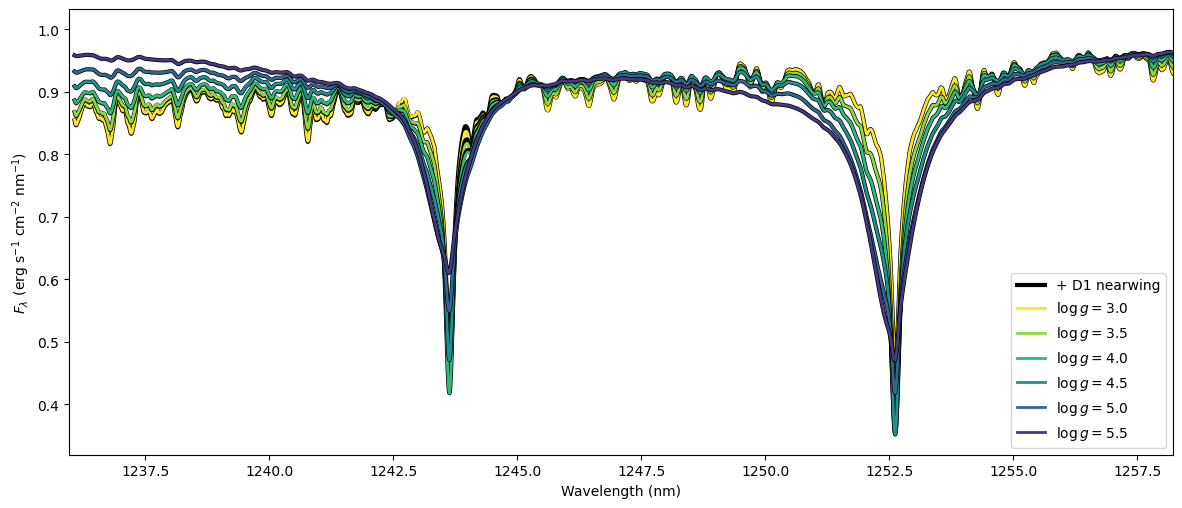

In [46]:
#h_ratios = [0.5,0.5]
h_ratios = [1]

fig, ax = plt.subplots(
    figsize=(12,5.5), nrows=1, sharex=True, sharey=True, 
    gridspec_kw={
        'height_ratios':h_ratios, 'hspace':0.03, 
        'left':0.06, 'right':0.98, 'top':0.95, 'bottom':0.14
        }
    )
try:
    ax = np.array(list(ax))
except:
    ax = np.array([ax])

for i in range(d_spec_1.n_orders):
    #ax[0].plot(m_spec_1.wave_pRT_grid[i], m_spec_1.flux_pRT_grid[i], c='C1', lw=2)
    for j, m_spec_j in enumerate(m_spec_1):
        
        label = None
        if j == 0:
            label = '+ D1 nearwing'

        ax[0].plot(
            m_spec_2[j].wave_pRT_grid[i], 
            m_spec_2[j].flux_pRT_grid[i]/np.nanmax(m_spec_2[j].flux_pRT_grid[i]), 
            #c=plt.get_cmap('viridis_r')(j/len(m_spec_1)), lw=2, ls='--'
            c='k', lw=3.0, ls='-', label=label
            )
        ax[0].plot(
            m_spec_j.wave_pRT_grid[i], 
            m_spec_j.flux_pRT_grid[i]/np.nanmax(m_spec_j.flux_pRT_grid[i]), 
            c=plt.get_cmap('viridis_r')(j/len(m_spec_1)), lw=2, 
            label=r'$\log g = $'+'{:.1f}'.format(all_log_g[j])
            )
        
        #ax[0].plot(
        #    m_spec_2[j].wave_pRT_grid[i], 
        #    m_spec_2[j].flux_pRT_grid[i]/np.nanmax(m_spec_2[j].flux_pRT_grid[i]), 
        #    c=plt.get_cmap('viridis_r')(j/5), lw=3, ls='--'
        #    )
        
ax[0].legend(loc='lower right')
ax[0].set(
    #xlim=(d_spec_1.wave[0,0].min()-1.5, d_spec_1.wave[0,1].max()+0.5), 
    xlim=(m_spec_1[0].wave_pRT_grid[0].min(), d_spec_1.wave[0,1].max()+0.5), 
    xlabel=r'Wavelength (nm)', 
    ylabel=r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$'
    )
plt.savefig('./plots/K_asymmetric_model.pdf')
plt.show()

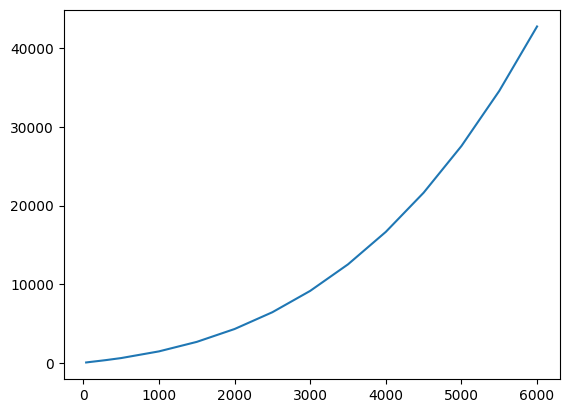

In [17]:
temperatures = np.array([
    37.5, 
    38,
    75,
    150,
    225,
    300,
    500,
    1000,
    1500,
    2000,
    2500,
    3000,
    3500,
    4000,
    4500,
    5000,
    5500,
    6000
    ])

theta = 5040/temperatures
a = np.array([3.5453,-2.3457,0.8557,-0.1685])
Q = 10**(
    a[0]*(np.log10(theta))**0 +
    a[1]*(np.log10(theta))**1 +
    a[2]*(np.log10(theta))**2 +
    a[3]*(np.log10(theta))**3
)
Q *= 8

plt.plot(temperatures, Q)
plt.show()

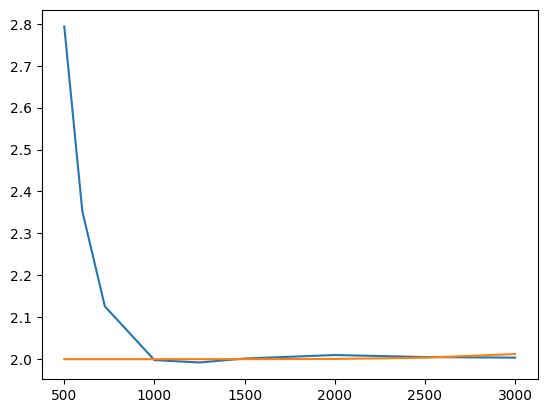

In [30]:
temperatures = np.array([
    500,
    600,
    725,
    1000,
    1250,
    1500,
    2000,
    2500,
    3000
    ])

theta = 5040/temperatures
a = np.array([0.34419,-0.48157,1.92563,-3.17826,1.83211])
Q = 10**(
    a[0]*(np.log10(theta))**0 +
    a[1]*(np.log10(theta))**1 +
    a[2]*(np.log10(theta))**2 +
    a[3]*(np.log10(theta))**3 +
    a[4]*(np.log10(theta))**4
)

Q_computed = np.array([
    2.0, 
    2.0000000000001643, 
    2.0000000000358216, 
    2.0000000437140493, 
    2.0000018540627478, 
    2.00002255970137, 
    2.000514648820947, 
    2.0033978089703206, 
    2.0122063094965887
])

plt.plot(temperatures, Q)
plt.plot(temperatures, Q_computed)
#plt.plot(temperatures, (1/Q)/(1/Q_computed))
#plt.yscale('log')
plt.show()